# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf
import math

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable}_conv2d_batchnorm() function.
    
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [21]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    print("\tSmall IP layer: {}".format(small_ip_layer.shape))
    print("\tLarge IP layer: {}".format(large_ip_layer.shape))

    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample_layer = bilinear_upsample(small_ip_layer)
    print("\tUpsample Layer: {}".format(upsample_layer.shape))
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    # If statement added to allow for skip layers
    if large_ip_layer == None:
        concatenate_layer = upsample_layer
    else:
        concatenate_layer = layers.concatenate([upsample_layer, large_ip_layer])

    print("\tConcatenate Layer: {}".format(concatenate_layer.shape))
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenate_layer, filters)
    print("\tSeperable Conv layer 1: {}".format(output_layer.shape))
   
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    print("\tSeperable Conv layer 2: {}".format(output_layer.shape))
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    print("\tSeperable Conv layer 3: {}".format(output_layer.shape))
    
    #output_layer = separable_conv2d_batchnorm(concatenate_layer, filters)
    #output_layer = separable_conv2d_batchnorm(concatenate_layer, filters)
    
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [22]:
#3 layers
def fcn_model(inputs, num_classes):
    
    print("Input: {}".format(inputs.shape))
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    en_filter = (32,64,128)

    en_strides = (2,2,2)
    en_layer_1 = encoder_block(inputs, en_filter[0],en_strides[0])
    print("Encoder layer 1: {}".format(en_layer_1.shape))
    en_layer_2 = encoder_block(en_layer_1, en_filter[1], en_strides[1])
    print("EN layer 2: {}".format(en_layer_2.shape))
    en_layer_3 = encoder_block(en_layer_2, en_filter[2], en_strides[2])
    print("En layer 3: {}".format(en_layer_3.shape))

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    
    convolution_layer = conv2d_batchnorm(en_layer_3, 256, kernel_size = 1, strides = 1) #512 bugged
    
    print("FCN convo layer: {}".format(convolution_layer.shape))
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    
    de_filter = en_filter[::-1]
    
    de_layer_1 = decoder_block(convolution_layer, en_layer_2, de_filter[0])
    print("Decoder Layer 1: {}".format(de_layer_1.shape))
    de_layer_2 = decoder_block(de_layer_1, en_layer_1, de_filter[1])
    print("Decoder Layer 2: {}".format(de_layer_2.shape))
    x = decoder_block(de_layer_2, inputs, de_filter[2])
    print("Output FCN: {}".format(x.shape))
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160 #original 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Input: (?, 160, 160, 3)
Encoder layer 1: (?, 80, 80, 32)
EN layer 2: (?, 40, 40, 64)
En layer 3: (?, 20, 20, 128)
FCN convo layer: (?, 20, 20, 256)
	Small IP layer: (?, 20, 20, 256)
	Large IP layer: (?, 40, 40, 64)
	Upsample Layer: (?, 40, 40, 256)
	Concatenate Layer: (?, 40, 40, 320)
	Seperable Conv layer 1: (?, 40, 40, 128)
	Seperable Conv layer 2: (?, 40, 40, 128)
	Seperable Conv layer 3: (?, 40, 40, 128)
Decoder Layer 1: (?, 40, 40, 128)
	Small IP layer: (?, 40, 40, 128)
	Large IP layer: (?, 80, 80, 32)
	Upsample Layer: (?, 80, 80, 128)
	Concatenate Layer: (?, 80, 80, 160)
	Seperable Conv layer 1: (?, 80, 80, 64)
	Seperable Conv layer 2: (?, 80, 80, 64)
	Seperable Conv layer 3: (?, 80, 80, 64)
Decoder Layer 2: (?, 80, 80, 64)
	Small IP layer: (?, 80, 80, 64)
	Large IP layer: (?, 160, 160, 3)
	Upsample Layer: (?, 160, 160, 64)
	Concatenate Layer: (?, 160, 160, 67)
	Seperable Conv layer 1: (?, 160, 160, 32)
	Seperable Conv layer 2: (?, 160, 160, 32)
	Seperable Conv layer 3: (?, 160, 

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [24]:
total_images = 4131
learning_rate = 0.001
batch_size = 100
num_epochs = 50
steps_per_epoch = math.ceil(total_images/batch_size)
validation_steps = math.ceil(steps_per_epoch*0.3)
workers = 8

Epoch 1/50
41/42 [============================>.] - ETA: 2s - loss: 1.0513

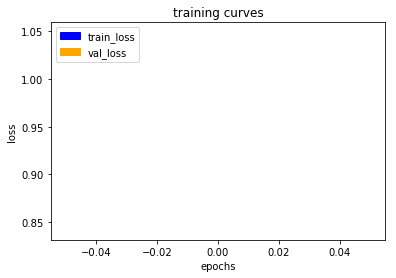

42/42 [==============================] - 104s - loss: 1.0464 - val_loss: 0.8416
Epoch 2/50
41/42 [============================>.] - ETA: 2s - loss: 0.6888

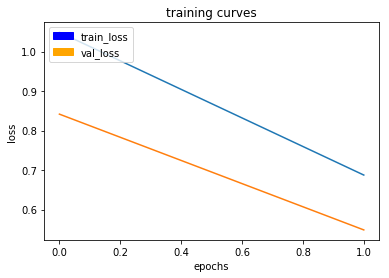

42/42 [==============================] - 101s - loss: 0.6850 - val_loss: 0.5483
Epoch 3/50
41/42 [============================>.] - ETA: 2s - loss: 0.3800

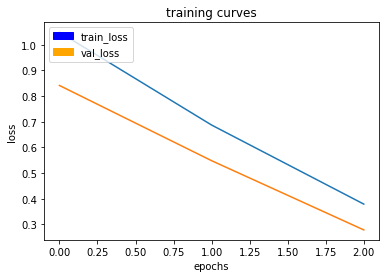

42/42 [==============================] - 103s - loss: 0.3770 - val_loss: 0.2784
Epoch 4/50
41/42 [============================>.] - ETA: 2s - loss: 0.1907

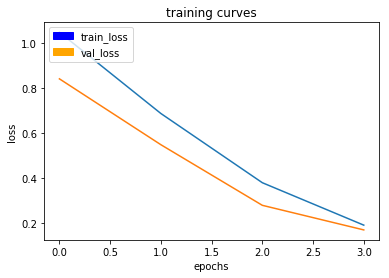

42/42 [==============================] - 101s - loss: 0.1895 - val_loss: 0.1689
Epoch 5/50
41/42 [============================>.] - ETA: 2s - loss: 0.1144

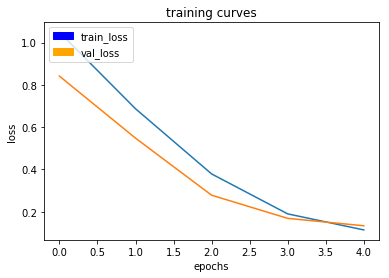

42/42 [==============================] - 101s - loss: 0.1139 - val_loss: 0.1338
Epoch 6/50
41/42 [============================>.] - ETA: 2s - loss: 0.0827

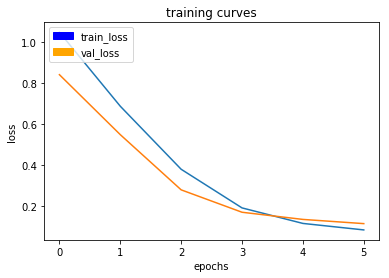

42/42 [==============================] - 101s - loss: 0.0824 - val_loss: 0.1133
Epoch 7/50
41/42 [============================>.] - ETA: 2s - loss: 0.0650

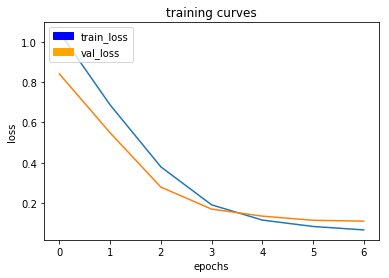

42/42 [==============================] - 101s - loss: 0.0652 - val_loss: 0.1089
Epoch 8/50
41/42 [============================>.] - ETA: 2s - loss: 0.0547

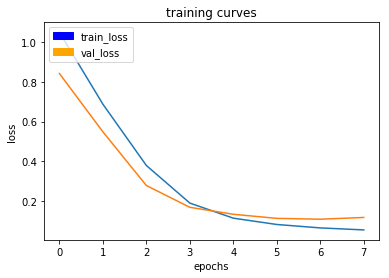

42/42 [==============================] - 102s - loss: 0.0551 - val_loss: 0.1178
Epoch 9/50
41/42 [============================>.] - ETA: 2s - loss: 0.0474

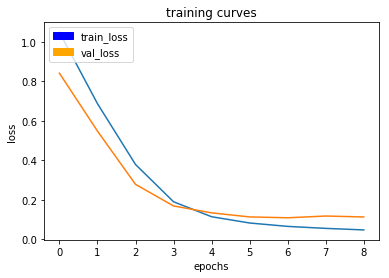

42/42 [==============================] - 102s - loss: 0.0473 - val_loss: 0.1130
Epoch 10/50
41/42 [============================>.] - ETA: 2s - loss: 0.0429

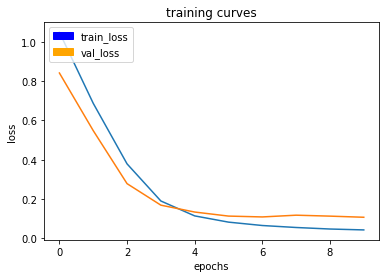

42/42 [==============================] - 102s - loss: 0.0428 - val_loss: 0.1073
Epoch 11/50
41/42 [============================>.] - ETA: 2s - loss: 0.0400

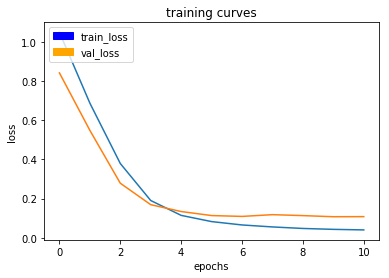

42/42 [==============================] - 101s - loss: 0.0399 - val_loss: 0.1078
Epoch 12/50
41/42 [============================>.] - ETA: 2s - loss: 0.0354

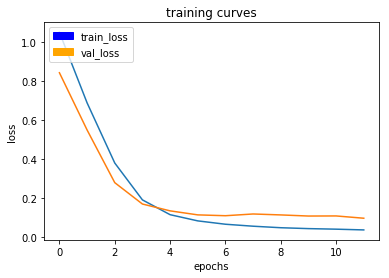

42/42 [==============================] - 101s - loss: 0.0361 - val_loss: 0.0961
Epoch 13/50
41/42 [============================>.] - ETA: 2s - loss: 0.0337

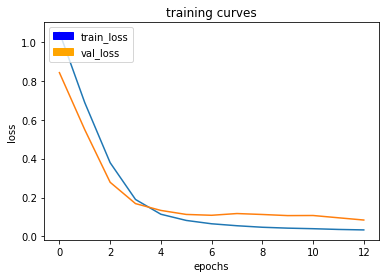

42/42 [==============================] - 101s - loss: 0.0336 - val_loss: 0.0845
Epoch 14/50
41/42 [============================>.] - ETA: 2s - loss: 0.0317

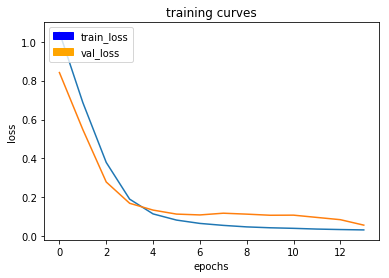

42/42 [==============================] - 102s - loss: 0.0317 - val_loss: 0.0564
Epoch 15/50
41/42 [============================>.] - ETA: 2s - loss: 0.0315

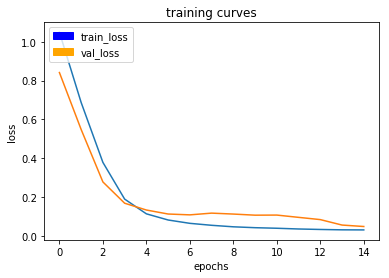

42/42 [==============================] - 101s - loss: 0.0314 - val_loss: 0.0489
Epoch 16/50
41/42 [============================>.] - ETA: 2s - loss: 0.0285

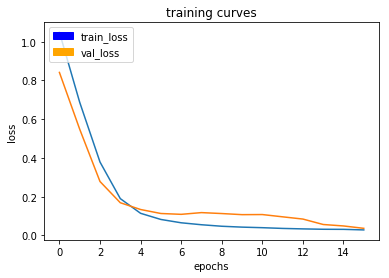

42/42 [==============================] - 102s - loss: 0.0285 - val_loss: 0.0367
Epoch 17/50
41/42 [============================>.] - ETA: 2s - loss: 0.0272

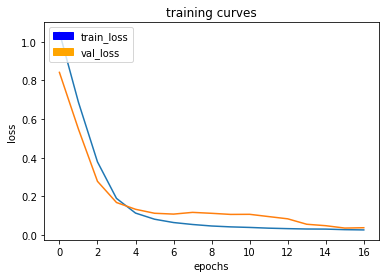

42/42 [==============================] - 101s - loss: 0.0271 - val_loss: 0.0385
Epoch 18/50
41/42 [============================>.] - ETA: 2s - loss: 0.0258

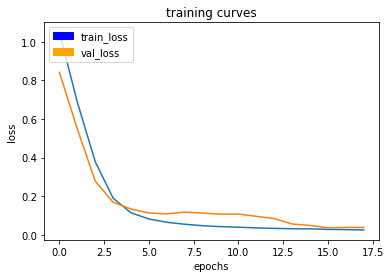

42/42 [==============================] - 102s - loss: 0.0258 - val_loss: 0.0385
Epoch 19/50
41/42 [============================>.] - ETA: 2s - loss: 0.0247

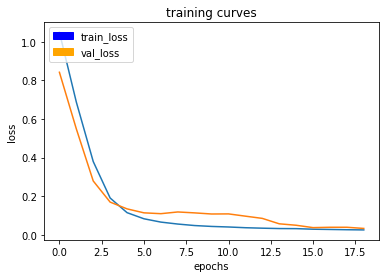

42/42 [==============================] - 101s - loss: 0.0248 - val_loss: 0.0325
Epoch 20/50
41/42 [============================>.] - ETA: 2s - loss: 0.0232

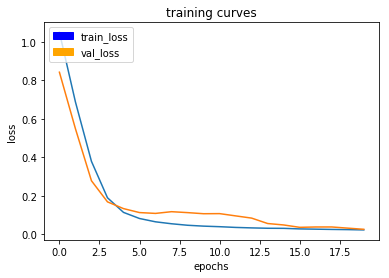

42/42 [==============================] - 101s - loss: 0.0232 - val_loss: 0.0265
Epoch 21/50
41/42 [============================>.] - ETA: 2s - loss: 0.0229

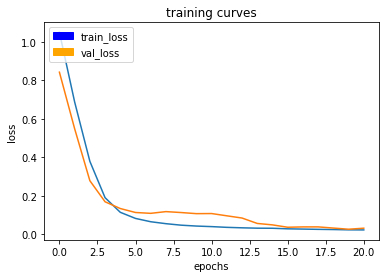

42/42 [==============================] - 103s - loss: 0.0227 - val_loss: 0.0317
Epoch 22/50
41/42 [============================>.] - ETA: 2s - loss: 0.0227

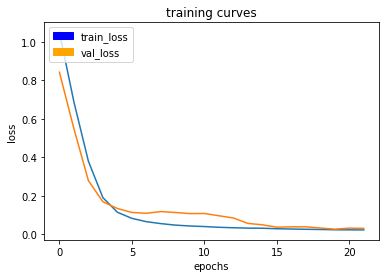

42/42 [==============================] - 101s - loss: 0.0227 - val_loss: 0.0303
Epoch 23/50
41/42 [============================>.] - ETA: 2s - loss: 0.0222

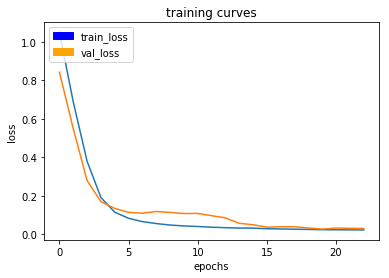

42/42 [==============================] - 101s - loss: 0.0221 - val_loss: 0.0296
Epoch 24/50
41/42 [============================>.] - ETA: 2s - loss: 0.0212

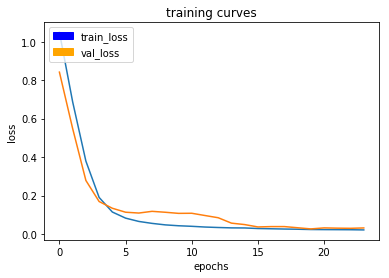

42/42 [==============================] - 101s - loss: 0.0211 - val_loss: 0.0314
Epoch 25/50
41/42 [============================>.] - ETA: 2s - loss: 0.0205

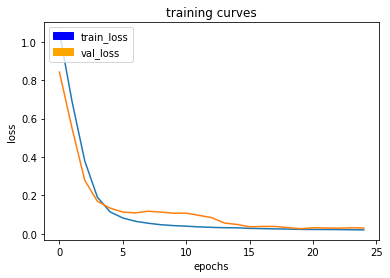

42/42 [==============================] - 101s - loss: 0.0204 - val_loss: 0.0300
Epoch 26/50
41/42 [============================>.] - ETA: 2s - loss: 0.0196

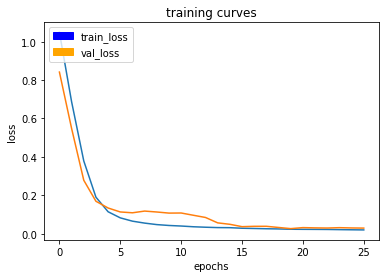

42/42 [==============================] - 101s - loss: 0.0196 - val_loss: 0.0292
Epoch 27/50
41/42 [============================>.] - ETA: 2s - loss: 0.0197

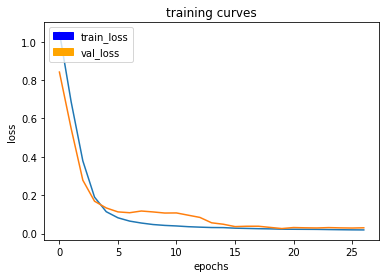

42/42 [==============================] - 102s - loss: 0.0197 - val_loss: 0.0303
Epoch 28/50
41/42 [============================>.] - ETA: 2s - loss: 0.0195

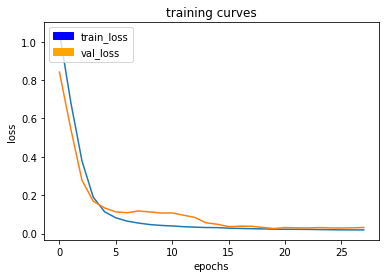

42/42 [==============================] - 103s - loss: 0.0196 - val_loss: 0.0319
Epoch 29/50
41/42 [============================>.] - ETA: 2s - loss: 0.0186

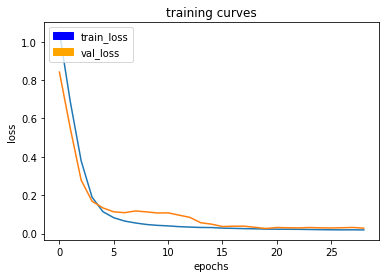

42/42 [==============================] - 101s - loss: 0.0191 - val_loss: 0.0282
Epoch 30/50
41/42 [============================>.] - ETA: 2s - loss: 0.0190

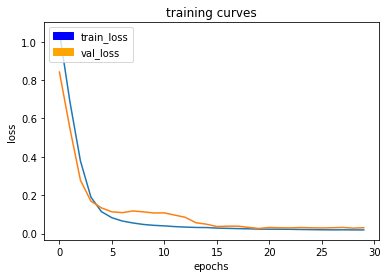

42/42 [==============================] - 101s - loss: 0.0189 - val_loss: 0.0305
Epoch 31/50
41/42 [============================>.] - ETA: 2s - loss: 0.0178

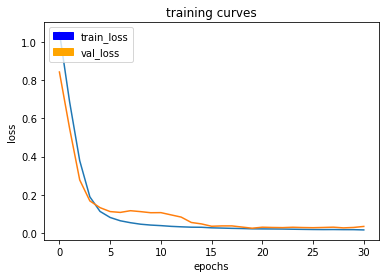

42/42 [==============================] - 102s - loss: 0.0178 - val_loss: 0.0357
Epoch 32/50
41/42 [============================>.] - ETA: 2s - loss: 0.0175

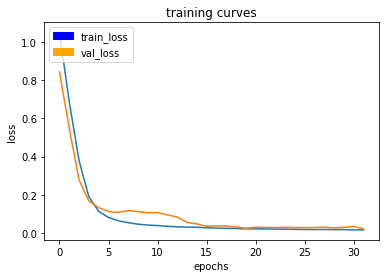

42/42 [==============================] - 101s - loss: 0.0174 - val_loss: 0.0220
Epoch 33/50
41/42 [============================>.] - ETA: 2s - loss: 0.0165

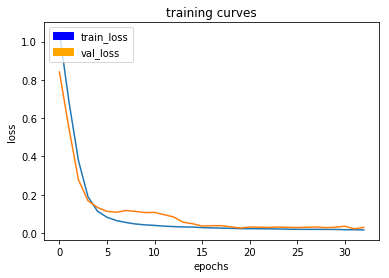

42/42 [==============================] - 101s - loss: 0.0165 - val_loss: 0.0296
Epoch 34/50
41/42 [============================>.] - ETA: 2s - loss: 0.0172

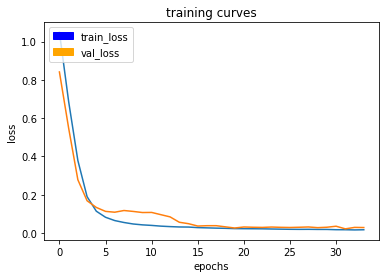

42/42 [==============================] - 101s - loss: 0.0172 - val_loss: 0.0288
Epoch 35/50
41/42 [============================>.] - ETA: 2s - loss: 0.0170

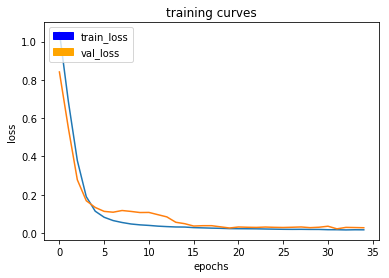

42/42 [==============================] - 102s - loss: 0.0170 - val_loss: 0.0278
Epoch 36/50
41/42 [============================>.] - ETA: 2s - loss: 0.0171

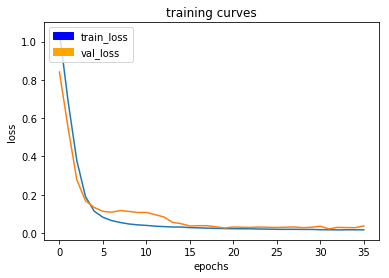

42/42 [==============================] - 101s - loss: 0.0171 - val_loss: 0.0376
Epoch 37/50
41/42 [============================>.] - ETA: 2s - loss: 0.0198

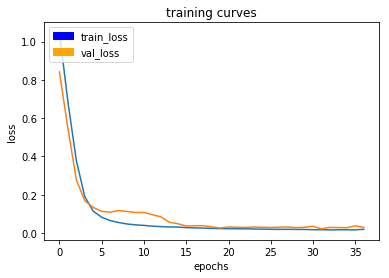

42/42 [==============================] - 101s - loss: 0.0198 - val_loss: 0.0298
Epoch 38/50
41/42 [============================>.] - ETA: 2s - loss: 0.0171

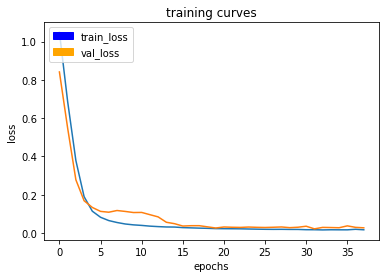

42/42 [==============================] - 102s - loss: 0.0171 - val_loss: 0.0274
Epoch 39/50
41/42 [============================>.] - ETA: 2s - loss: 0.0161

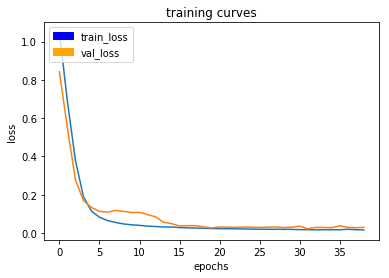

42/42 [==============================] - 101s - loss: 0.0161 - val_loss: 0.0296
Epoch 40/50
41/42 [============================>.] - ETA: 2s - loss: 0.0153

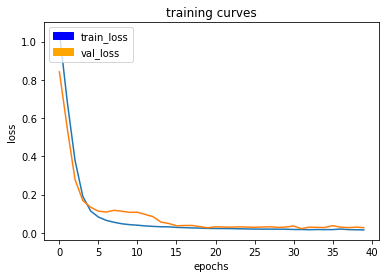

42/42 [==============================] - 101s - loss: 0.0153 - val_loss: 0.0272
Epoch 41/50
41/42 [============================>.] - ETA: 2s - loss: 0.0150

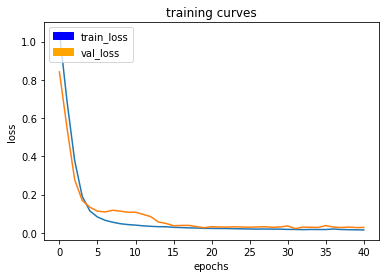

42/42 [==============================] - 102s - loss: 0.0150 - val_loss: 0.0278
Epoch 42/50
41/42 [============================>.] - ETA: 2s - loss: 0.0147

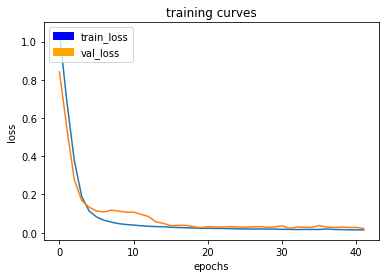

42/42 [==============================] - 101s - loss: 0.0146 - val_loss: 0.0218
Epoch 43/50
41/42 [============================>.] - ETA: 2s - loss: 0.0147

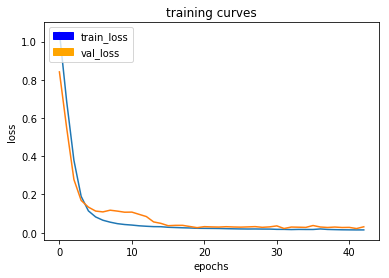

42/42 [==============================] - 101s - loss: 0.0147 - val_loss: 0.0310
Epoch 44/50
41/42 [============================>.] - ETA: 2s - loss: 0.0140

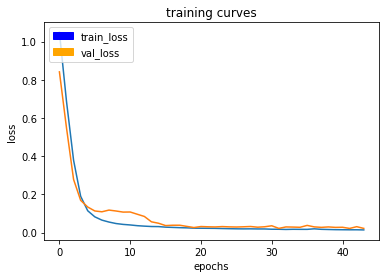

42/42 [==============================] - 102s - loss: 0.0140 - val_loss: 0.0219
Epoch 45/50
41/42 [============================>.] - ETA: 2s - loss: 0.0160

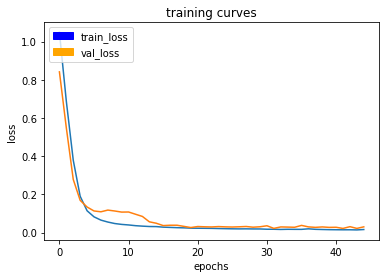

42/42 [==============================] - 102s - loss: 0.0160 - val_loss: 0.0300
Epoch 46/50
41/42 [============================>.] - ETA: 2s - loss: 0.0153

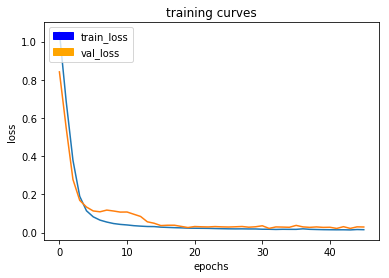

42/42 [==============================] - 101s - loss: 0.0152 - val_loss: 0.0292
Epoch 47/50
41/42 [============================>.] - ETA: 2s - loss: 0.0152

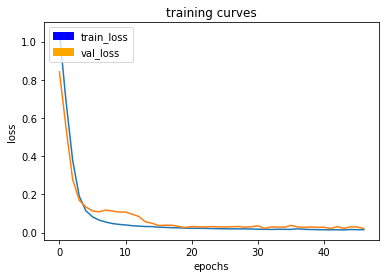

42/42 [==============================] - 102s - loss: 0.0151 - val_loss: 0.0220
Epoch 48/50
41/42 [============================>.] - ETA: 2s - loss: 0.0139

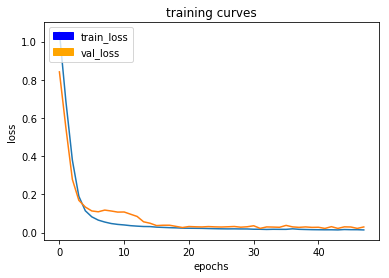

42/42 [==============================] - 101s - loss: 0.0139 - val_loss: 0.0295
Epoch 49/50
41/42 [============================>.] - ETA: 2s - loss: 0.0133

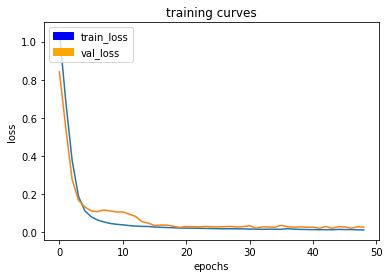

42/42 [==============================] - 103s - loss: 0.0134 - val_loss: 0.0278
Epoch 50/50
41/42 [============================>.] - ETA: 2s - loss: 0.0134

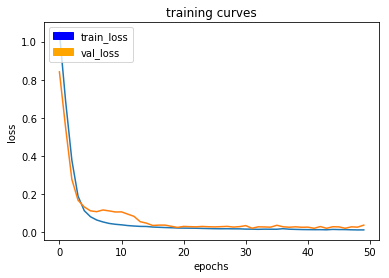

42/42 [==============================] - 101s - loss: 0.0135 - val_loss: 0.0384


In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [36]:
# Save your trained model weights
weight_file_name = 'model_weights_project_final'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

#weight_file_name = 'model_weights_36_32_64_128_256_filter_bilinear_2_2x_convolayer_3x_encoder_decoder_0001_learningrate_image_160_epoch200'
#restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [37]:
run_num = 'run_project_final'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

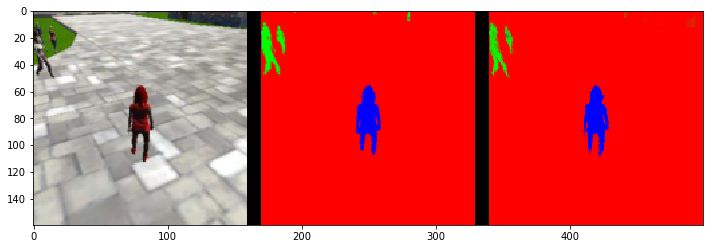

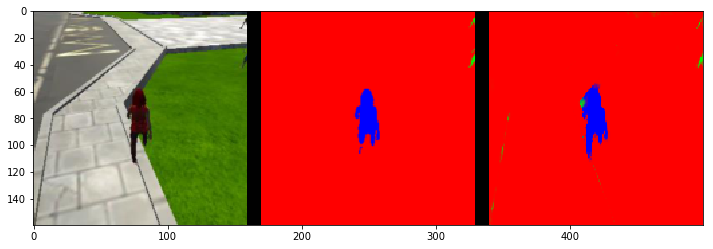

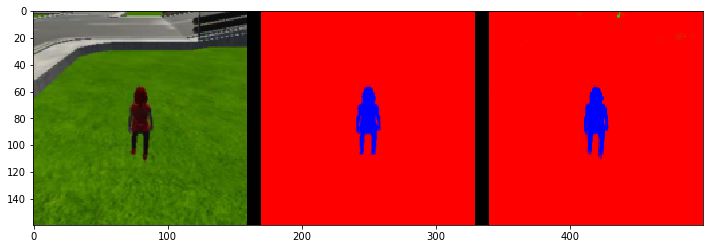

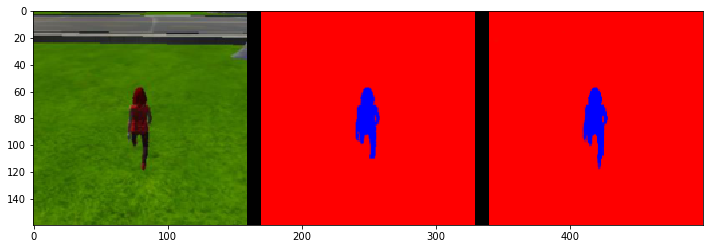

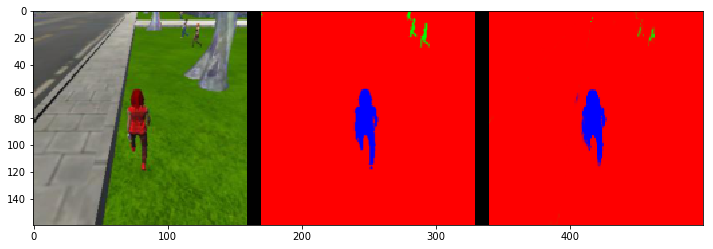

In [38]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 

for i in range(5):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

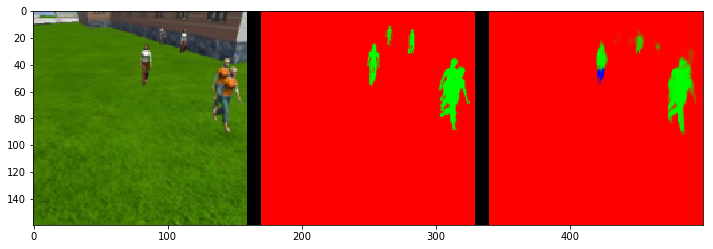

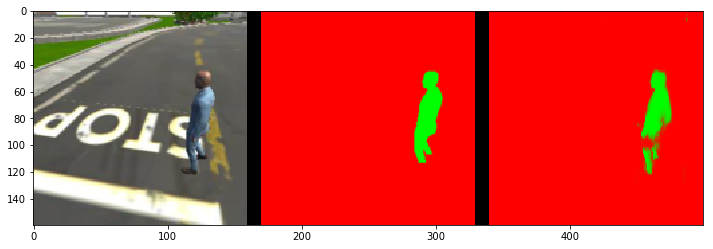

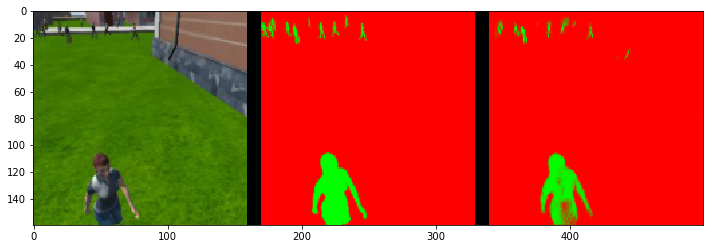

In [39]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

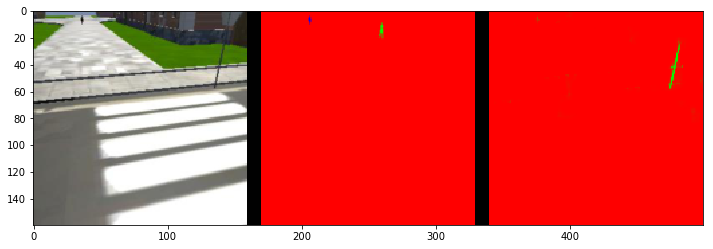

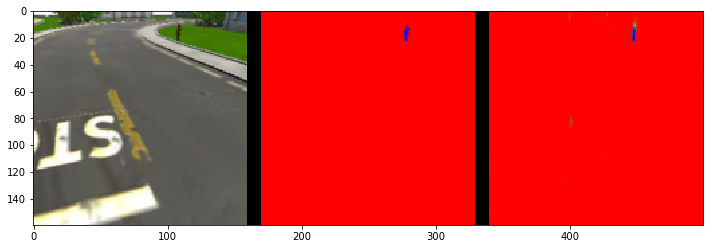

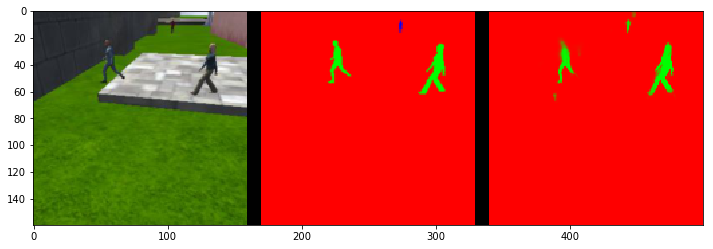

In [40]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [41]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9956230097373997
average intersection over union for other people is 0.35097612399823225
average intersection over union for the hero is 0.9153213941101979
number true positives: 539, number false positives: 0, number false negatives: 0


In [42]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9854393305604726
average intersection over union for other people is 0.6916829623811418
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 73, number false negatives: 0


In [43]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9962828488107042
average intersection over union for other people is 0.4235383378170788
average intersection over union for the hero is 0.2274659222652093
number true positives: 136, number false positives: 2, number false negatives: 165


In [44]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7377049180327869


In [45]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.571393658188


In [46]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.421519911778


In [ ]:
'''
3x seperable convolution layers
0.3167122067647197

2x  SCL

0.27981067139275323

5x everything

0.2829935187724299

1x everything 
0.193

2x seperable convolutional layers, 1x everything else
0.16372800343361454

2x SCL, 3x encoder/decoder, 32 filters all
0.2827647074681242

5x SCL, 3x everything else

0.2610517730675183

4x encoder-decoder, 5x SCL
0.29978788963819764


4x encoder-decoder, 5x SCL, 3 kernel
0.29900070117265926


4x encoder-decoder, 1 kernel, 1x SCL, batch size 8, image size 256
0.0

3x SCL, other source code, 45 epochs
0.3160082125553557

70 epochs
0.34984870081914754

110 epochs
0.39336736092606767

200 epochs, learning rate = 0.00005
0.3981144407054792
50 epochs, 160x160
0.28777501210053974

50 epochs, 32-64-128-256 filter

0.32520881163950077

50 epochs, 32-64-128-256 filter, 5x encoder decoder, 3x seperable convolution layers

0.27724147196338345

150 epochs, 32-64-126-256. 160x160

0.32451424192333617

50 epochs, 32-32-32-32 filter
0.29976685871940034
0.28974043508349573

150 epochs, 32-64-128 160 x 160
0.3853258733899725

50 epochs, 4x4 bilinear 160 x 160 2 encoder/decoder layers
0.22108090068398303

50 epochs, 64-64-64-64 filter, 4x encoder/decoder, output 3 layers, 3x seperable convolution layers
0.27004945766212324
2x seperable convolution layers
0.26956867277801133

50 epochs, 64-64-128-128 filter, 4x encoder/decoder, output 3 layers, 3x seperable convolution layers
.28712743048353

5x seperable convolution layers
0.257274771165236

50 epochs, 32-64-128-256 filter, 5x encoder decoder, 2x seperable convolution layers
0.2897116310402909

50 eophcs, 32-32-64-64 filter, 4x encoder decoder, 2x seperable convolution layers
0.3042621027625398

50 eophcs, 32-32-64-64 filter, 5x encoder decoder, 2x seperable convolution layers
0.22319551905906787

150 epochs, 32-32-64-64 filter, 3x encoder decoder, 2x scl
0.3538327657132072

100 epochs, 16-32-64-128 filter, 3x encoder decoder, 2x scl
0.32797508781544776

100 epochs, 16-16-16-16 filter, 3x encoder decoder, 2x scl
0.2952234899277609

100 epochs, 32-32-32-32-32 filter, 5x encoder decoder, 2x scl
0.3384246076758665

100 epochs, 32-32-64-64-64 filter, 5x encoder decoder, 2x scl, 1-2-3 skip
0.3444062095412918

100 epochs, 32-32-64-64-64 filter, 5x encoder decoder, 2x scl, 1-3 skip
0.33793336695255777

200 epochs 32-32-64-64-64 filter, 5x encoder decoder, 2x scl, 1-3 skip
0.30964816725857175

10 epochs, learning 0.01. 16-32-64-128, 3x encoder decoder, 1x scl, no skips
0.3126764560244361

50 epochs, learning 0.001 16-32-64-128 3x encoder decoder, 1x scl, no skips
0.38783271227095134

75 epochs, learning 0.0005 16-32-64-128 3x encoder decoder, 1x scl, no skips
0.34219104909424625

50 epochs, learning 0.001 32-64-128-256 3x encoder decoder, 1x scl, no skips 
0.39073393868989764

200 epochs, learning 0.001 32-64-128-256 3x encoder decoder, 2x scl,  
'''